# Applied Neural Networks Homework 2
Leslie Kerby

# **MNIST Digits and Keras continued**</br>
Import in the MNIST digits dataset (70,000 images, each 28x28 pixels). Preprocess the data as necessary. The training set should have 60k images and the test set 10k. Also create a validation set within the training set -- using 10% of the training data. 

**Part 1** </br>
Create a deep and wide neural network using the Keras Functional API (exact architecture left up to you). Train it for an appropriate number of epochs with an appropriate learning rate and plot the accuracy/loss vs epoch. Find the accuracy on the test data and plot the first five misclassified images. 

**Part 2**</br>
Use the subclassing API to create a different multi-path network than Part 1 (ie, a deep and wide network is multi-path) with two different inputs. Send all pixels in one input and a subset of pixels in the second input. Experiment with different architectures. Train it for an appropriate number of epochs with an appropriate learning rate and plot the accuracy/loss vs epoch. Find the accuracy on the test data and plot the first five misclassified images.

**Part 3**</br>
Which NN was the best? What was its accuracy? It's confusion matrix? Discuss. 

# **Part 1**

In [79]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

np.random.seed(15)
tf.random.set_seed(15)

mnist_digits = keras.datasets.mnist
(X_train_full, Y_train_full), (X_test, Y_test) = mnist_digits.load_data()
# preprocess
X_train_full = X_train_full / 255
X_test = X_test / 255
# Reshape
X_train_full = X_train_full.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# Validation Dataset
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full, Y_train_full, test_size=5000)

In [80]:
X_train_tr.shape

(55000, 784)

In [81]:
# Create the Deep Wide NN. Only a small number of 30 neurons per hidden layer for now
input = keras.layers.Input(shape=(784,), name="input")
hidden1 = keras.layers.Dense(30, activation="relu", name="Hidden1")(input)
hidden2 = keras.layers.Dense(30, activation="relu", name="Hidden2")(hidden1)
concat = keras.layers.Concatenate()([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input], outputs=[output])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3), metrics="accuracy")

In [82]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 Hidden1 (Dense)                (None, 30)           23550       ['input[0][0]']                  
                                                                                                  
 Hidden2 (Dense)                (None, 30)           930         ['Hidden1[0][0]']                
                                                                                                  
 concatenate_17 (Concatenate)   (None, 814)          0           ['input[0][0]',                  
                                                                  'Hidden2[0][0]']          

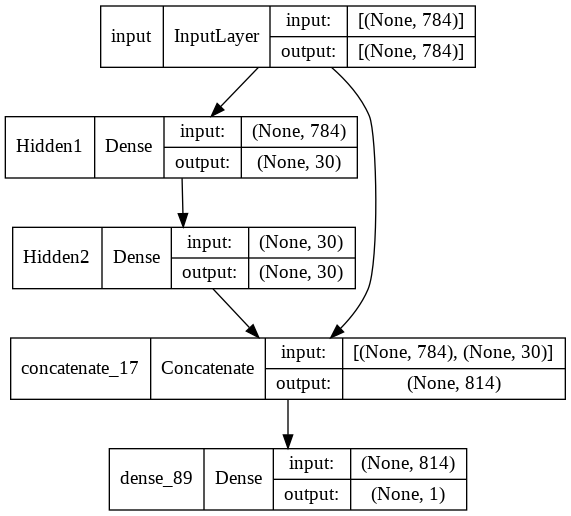

In [83]:
keras.utils.plot_model(model, show_shapes=True)

In [84]:
history = model.fit(X_train_tr, y_train_tr, epochs=20, validation_data=(X_train_v, y_train_v))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 2.7463 - accuracy: 0.1521 - val_loss: 1.4135 - val_accuracy: 0.1808
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3134 - accuracy: 0.1747 - val_loss: 1.0645 - val_accuracy: 0.1732
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0761 - accuracy: 0.1792 - val_loss: 1.4142 - val_accuracy: 0.1506
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9556 - accuracy: 0.1833 - val_loss: 0.8808 - val_accuracy: 0.1886
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8818 - accuracy: 0.1848 - val_loss: 1.1565 - val_accuracy: 0.1736
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8283 - accuracy: 0.1873 - val_loss: 0.8772 - val_accuracy: 0.1848
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7794 - accuracy: 0.1884 - val_loss: 0.8226 - val_accuracy:

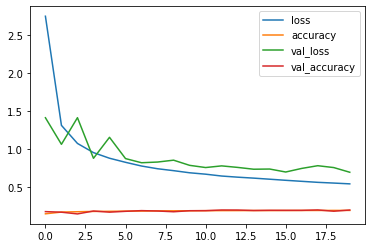

In [85]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [86]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7313 - accuracy: 0.1974


[0.7313029170036316, 0.19740000367164612]

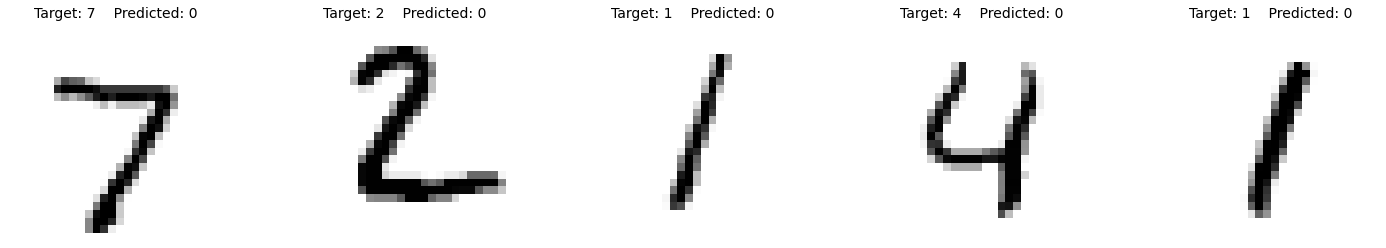

In [91]:
# Find some of the misclassified numbers
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

predictions = np.argmax(model.predict(X_test), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(Y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(28,28), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[Y_test[misclassifiedIndexes[index]]]}    Predicted: {classes[predictions[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

#Evaluation of Part 1 Model
Using a very simple Deep and Wide Neural Network with a low number of neurons proved to be very inefficient for identifying numbers correctly. The overall accuracy of the model was only about 20% and had a loss of around 73%. This is extremely clear when looking at some of the elements that were misidentified. The first 5 elements shown are all extremely obvious as to what the correct answer should be but because the model is not very complex at all it has trouble with even simple identifications. The model needs to be refined by a large margin to be even somewhat functional. Making improvements will be left to part 2 using the subclassing API.

# **Part 2**

In [94]:
# Here is where we define our Wide and Deep class
class WideAndDeepModel(keras.models.Model):
  # units is number of default neurons
  # activation is the default activation function
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.hidden3 = keras.layers.Dense(units, activation=activation)
    self.hidden4 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)
    self.concat = keras.layers.Concatenate()

  def call(self, inputs):
    input_A, input_B = inputs
    # We have 4 hidden layers where input B goes through the 4 layers then
    # gets concatenated then passed to main output. Input A goes straight
    # to the concat layer then the main output
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    hidden3 = self.hidden3(hidden2)
    hidden4 = self.hidden4(hidden3)
    concat = self.concat([input_A, hidden4])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden4)
    return main_output, aux_output

model = WideAndDeepModel(units=30, activation="relu")

In [96]:
model.compile(loss="mse", loss_weights=[0.2, 0.8], optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3), metrics=["accuracy"])

In [54]:
# this will fit the model using 2 different inputs. It will use one input with
# all of the pixels then another input using half the pixels. (784px / 2 = 392px)
# This model specs:
# -> 200 neurons
# -> 4 hidden layers
# -> loss_weights [0.9, 0.1]
# -> learning rate = 5e-3
# -> Input_A = half pixels
# -> Input_B = All pixels
# -> 20 epochs
# result:   loss: 0.0521 - output_1_loss: 0.0511 - output_2_loss: 0.0616 
#           output_1_accuracy: 0.2095 - output_2_accuracy: 0.2089
#             
#           val_loss: 0.3134 - val_output_1_loss: 0.3123 - val_output_2_loss: 0.3227 
#           val_output_1_accuracy: 0.2124 - val_output_2_accuracy: 0.2116
history = model.fit((X_train_tr[:,392:], X_train_tr), [y_train_tr, y_train_tr], 
                    epochs=20, validation_data=((X_train_v[:,392:], X_train_v), [y_train_v, y_train_v]))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 2.0646 - output_1_loss: 2.0418 - output_2_loss: 2.2696 - output_1_accuracy: 0.1694 - output_2_accuracy: 0.1512 - val_loss: 0.9207 - val_output_1_loss: 0.9180 - val_output_2_loss: 0.9452 - val_output_1_accuracy: 0.1982 - val_output_2_accuracy: 0.1942
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8493 - output_1_loss: 0.8478 - output_2_loss: 0.8629 - output_1_accuracy: 0.1928 - output_2_accuracy: 0.1917 - val_loss: 0.7017 - val_output_1_loss: 0.6995 - val_output_2_loss: 0.7218 - val_output_1_accuracy: 0.1990 - val_output_2_accuracy: 0.1972
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6134 - output_1_loss: 0.6121 - output_2_loss: 0.6253 - output_1_accuracy: 0.1989 - output_2_accuracy: 0.1988 - val_loss: 1.4275 - val_output_1_loss: 1.4507 - val_output_2_loss: 1.2187 - val_output_1_accuracy: 0.1834 - val_output_2_accuracy: 0.1878
Epoch 4/20
1719/1719 [

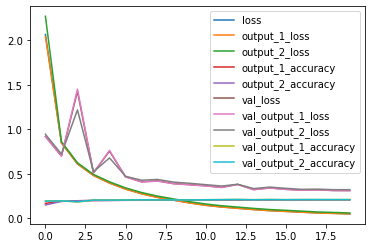

In [55]:
# Graph for model 1
pd.DataFrame(history.history).plot()

In [64]:
# Tried increasing neurons
# This model specs:
# -> 500 neurons
# -> 4 hidden layers
# -> loss_weights [0.9, 0.1]
# -> learning rate = 5e-3
# -> Input_A = half pixels
# -> Input_B = All pixels
# -> 20 epochs
# results:    loss: 0.0276 - output_1_loss: 0.0268 - output_2_loss: 0.0345 
#             output_1_accuracy: 0.2097 - output_2_accuracy: 0.2092
# 
#             val_loss: 0.2964 - val_output_1_loss: 0.2954 - val_output_2_loss: 0.3053 
#             val_output_1_accuracy: 0.2128 - val_output_2_accuracy: 0.2118  
# From this I can see the amount of neurons has pretty much 0 effect
history = model.fit((X_train_tr[:,392:], X_train_tr), [y_train_tr, y_train_tr], 
                    epochs=20, validation_data=((X_train_v[:,392:], X_train_v), [y_train_v, y_train_v]))

Epoch 1/20
1719/1719 [==============================] - 8s 5ms/step - loss: 1.9296 - output_1_loss: 1.9101 - output_2_loss: 2.1047 - output_1_accuracy: 0.1717 - output_2_accuracy: 0.1552 - val_loss: 0.8461 - val_output_1_loss: 0.8413 - val_output_2_loss: 0.8899 - val_output_1_accuracy: 0.1972 - val_output_2_accuracy: 0.1886
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7810 - output_1_loss: 0.7791 - output_2_loss: 0.7983 - output_1_accuracy: 0.1933 - output_2_accuracy: 0.1914 - val_loss: 0.6154 - val_output_1_loss: 0.6125 - val_output_2_loss: 0.6407 - val_output_1_accuracy: 0.1956 - val_output_2_accuracy: 0.1932
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5450 - output_1_loss: 0.5430 - output_2_loss: 0.5628 - output_1_accuracy: 0.1986 - output_2_accuracy: 0.1971 - val_loss: 1.1475 - val_output_1_loss: 1.1637 - val_output_2_loss: 1.0011 - val_output_1_accuracy: 0.1894 - val_output_2_accuracy: 0.1904
Epoch 4/20
1719/1719 [

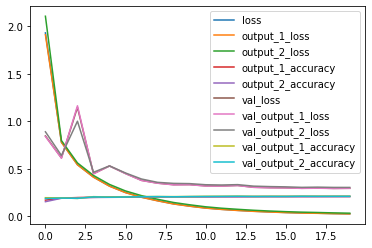

In [65]:
# From model 2
pd.DataFrame(history.history).plot()

In [97]:
# 
# This model specs:
# -> 30 neurons
# -> 4 hidden layers
# -> loss_weights [0.9, 0.1]
# -> learning rate = 5e-6
# -> Input_A = half pixels
# -> Input_B = all pixels
# -> 20 epochs
# results:    loss: 0.9527 - output_1_loss: 0.9386 - output_2_loss: 1.0791
#             output_1_accuracy: 0.1928 - output_2_accuracy: 0.2011
#
#             val_loss: 1.1247 - val_output_1_loss: 1.1076 - val_output_2_loss: 1.2791
#             val_output_1_accuracy: 0.1866 - val_output_2_accuracy: 0.2062
# 
history = model.fit((X_train_tr[:,392:], X_train_tr), [y_train_tr, y_train_tr], 
                    epochs=20, validation_data=((X_train_v[:,392:], X_train_v), [y_train_v, y_train_v]))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 2.3639 - output_1_loss: 2.5432 - output_2_loss: 2.3191 - output_1_accuracy: 0.1541 - output_2_accuracy: 0.1667 - val_loss: 1.1191 - val_output_1_loss: 1.2096 - val_output_2_loss: 1.0964 - val_output_1_accuracy: 0.1890 - val_output_2_accuracy: 0.2008
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0197 - output_1_loss: 1.0772 - output_2_loss: 1.0053 - output_1_accuracy: 0.1915 - output_2_accuracy: 0.1955 - val_loss: 0.9873 - val_output_1_loss: 1.0184 - val_output_2_loss: 0.9795 - val_output_1_accuracy: 0.1970 - val_output_2_accuracy: 0.1984
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8063 - output_1_loss: 0.8405 - output_2_loss: 0.7977 - output_1_accuracy: 0.1982 - output_2_accuracy: 0.1985 - val_loss: 1.3793 - val_output_1_loss: 1.4416 - val_output_2_loss: 1.3637 - val_output_1_accuracy: 0.1874 - val_output_2_accuracy: 0.1866
Epoch 4/20
1719/1719 [

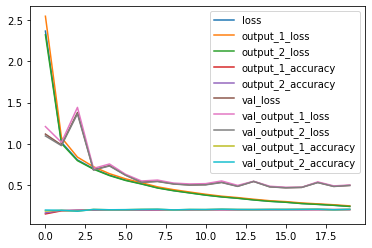

In [98]:
# From model 3
pd.DataFrame(history.history).plot()

# Evaluation of Models

# **Part 3**